In [2]:
from urllib.request import urlopen, Request
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Normalizer
from urllib.request import urlopen
from matplotlib import pyplot as plt
import math
import datetime
from time import sleep
import copy
import json
import sys
import csv
import pandas as pd
import numpy as np
from scipy.stats.stats import pearsonr   
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.utils import shuffle
import seaborn as sns; sns.set(color_codes=True)
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score

In [27]:
def Predict(df, scaler = None, classifier = RandomForestClassifier(n_estimators=101, random_state=0), columns = None):
    print(df.shape)
    df.drop(df.tail(7).index,inplace=True) #missing data from news
    
    if columns is None:
        df = df.drop(['date','target_price', 'open_price', 'close_price'], axis = 1) # delete non-numeric columns
    else:
        target = df['target_rise_fall']
        df = df[columns].copy()
        df['target_rise_fall'] = target
        
    X = df.loc[:, df.columns != 'target_rise_fall']
    y = df.loc[:, df.columns == 'target_rise_fall']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    X_train_r = X_train.copy()
    if scaler is not None:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    classifier.fit(X_train, y_train.values.ravel())
    y_pred = classifier.predict(X_test)
    print("---------------------Summary------------------")
    print(classification_report(y_test,y_pred))
    print("----------------Confusion_matrix--------------")
    print(confusion_matrix(y_test,y_pred))
    print("--------------------Accuracy------------------")
    print(accuracy_score(y_test, y_pred))
    
    df_cm = confusion_matrix(y_test,y_pred)
    #plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
    plt.title('Confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.show()
    
    return  classifier , X_train_r
    
def DefineThreeClasses(df):
    df['target_rise_fall'] = np.where((df.target > 100.00),'Rise',df.target_rise_fall)
    df['target_rise_fall'] = np.where((df.target <-100.00),'Fall',df.target_rise_fall)
    df['target_rise_fall'] = np.where(((df.target >=-100) & (df.target <=100)),'Stay',df.target_rise_fall)
    print('Rise'+ str(df[df.target_rise_fall == 'Rise'].shape[0]))
    print('Fall'+ str(df[df.target_rise_fall == 'Fall'].shape[0]))
    print('Stay'+ str(df[df.target_rise_fall == 'Stay'].shape[0]))
    return df
    

In [4]:
def DefineHistoricalPrices(df):
    df['cprice_t-1'] = df.close_price.shift(1)
    df['cprice_t-2'] = df.close_price.shift(2)
    df['cprice_t-3'] = df.close_price.shift(3)
    df['cprice_t-4'] = df.close_price.shift(4)
    df['cprice_t-5'] = df.close_price.shift(5)
    
    df['oprice_t-1'] = df.open_price.shift(1)
    df['oprice_t-2'] = df.open_price.shift(2)
    df['oprice_t-3'] = df.open_price.shift(3)
    df['oprice_t-4'] = df.open_price.shift(4)
    df['oprice_t-5'] = df.open_price.shift(5)
    return df

def DefineTarget(df):
    df['my_feature2'] = df.tweet_volume * (df.avg_sum_positive-df.avg_sum_negative)
    df['tomorow_percentage_rise_fall'] = df.close_price.pct_change()*100
    df['tomorow_percentage_rise_fall'] = df['tomorow_percentage_rise_fall'].shift(-1)
    df['target_rise_fall'] = (df.tomorow_percentage_rise_fall>0)
    df['target_rise_fall']=df['target_rise_fall'].astype('int')
    #df = df.drop(['tomorow_percentage_rise_fall'], axis = 1)
    df = df.shift(-5)
    df.drop(df.tail(7).index,inplace=True)
    return df

def DefineThreeTarget(df):
    df['d_target_price'] = np.append(np.diff(df['close_price']), 0)
    df['target_rise_fall'] = df[['d_target_price']].copy()
    df['my_feature2'] = df.tweet_volume * (df.avg_sum_positive-df.avg_sum_negative)

    df['target_rise_fall'] = np.where((df.d_target_price > 100.00),'Buy',df.target_rise_fall)
    df['target_rise_fall'] = np.where((df.d_target_price <-100.00),'Sell',df.target_rise_fall)
    df['target_rise_fall'] = np.where(((df.d_target_price >=-100) & (df.d_target_price <=100)),'Hold',df.target_rise_fall)
    df = df.drop(['d_target_price'], axis = 1)
    
    df = df.shift(-5)
    df.drop(df.tail(7).index,inplace=True)
    
    print('Buy'+ str(df[df.target_rise_fall == 'Buy'].shape[0]))
    print('Sell'+ str(df[df.target_rise_fall == 'Sell'].shape[0]))
    print('Hold'+ str(df[df.target_rise_fall == 'Hold'].shape[0]))
    
    return df
    
def GetCategoryDataset(name):
    df = pd.read_csv("data_f.csv")
    
    if name=='btchistorical':
        dfr = df[['dayOfWeek_sin', 'dayOfWeek_cos', 'is_Weekend', 'open_price', 'close_price', 'market_volume', 'market_cap', 'num_of_transaction', 'd_num_of_transaction', 'miners_revenue', 'd_miners_revenue', 'output_volume', 'd_output_volume', 'total_trans_fees', 'd_total_trans_fees']].copy()
    if name=='tweettrends':
        dfr = df[['my_feature2','dayOfWeek_sin', 'dayOfWeek_cos', 'is_Weekend', 'open_price', 'close_price', 'bitcoin_trends', 'd_bitcoin_trends', 'crypto_trends', 'd_crypto_trends', 'tweet_volume', 'nonzero_neutral_tweet', 'nonzero_positive_tweet', 'nonzero_negative_tweet', 'nonzero_compound_tweet', 'sum_positive_mul_follow', 'sum_neutral_mul_follow', 'sum_negative_mul_follow', 'sum_compound_mul_follow', 'sum_positive', 'sum_neutral', 'sum_negative', 'sum_compound', 'avg_sum_positive', 'avg_sum_neutral', 'avg_sum_negative', 'avg_sum_compound', 'avg_sum_nonzero_positive', 'avg_sum_nonzero_neutral', 'avg_sum_nonzero_negative', 'avg_sum_nonzero_compound', 'avg_sum_positive_mul_follow', 'avg_sum_neutral_mul_follow', 'avg_sum_negative_mul_follow', 'avg_sum_compound_mul_follow', 'avg_sum_nonzero_positive_mul_follow', 'avg_sum_nonzero_neutral_mul_follow', 'avg_sum_nonzero_negative_mul_follow', 'avg_sum_nonzero_compound_mul_follow', 'fear_factor_index', 'd_fear_factor']].copy()
    if name=='news':
        dfr = df[['dayOfWeek_sin', 'dayOfWeek_cos', 'is_Weekend', 'open_price', 'close_price', 'sum_clheaders_negative', 'sum_clheaders_positive', 'sum_clheaders_neutral', 'sum_clheaders_compound', 'avg_clheaders_negative', 'avg_clheaders_positive', 'avg_clheaders_neutral', 'avg_clheaders_compound', 'sum_headers_negative', 'sum_headers_positive', 'sum_headers_neutral', 'sum_headers_compound', 'avg_headers_negative', 'avg_headers_positive', 'avg_headers_neutral', 'avg_headers_compound', 'sum_clcontents_negative', 'sum_clcontents_positive', 'sum_clcontents_neutral', 'sum_clcontents_compound', 'avg_clcontents_negative', 'avg_clcontents_positive', 'avg_clcontents_neutral', 'avg_clcontents_compound', 'sum_contents_negative', 'sum_contents_positive', 'sum_contents_neutral', 'sum_contents_compound', 'avg_contents_negative', 'avg_contents_positive', 'avg_contents_neutral', 'avg_contents_compound']].copy()
    if name=='stockmarket':
        dfr = df[['dayOfWeek_sin', 'dayOfWeek_cos', 'is_Weekend', 'open_price', 'close_price', 'cobalt_price', 'd_cobalt_price', 'oil_price', 'd_oil_price', 'amd_price', 'amd_volume', 'd_amd_price', 'd_amd_volume', 'intel_price', 'intel_volume', 'd_intel_price', 'd_intel_volume', 'nvidia_price', 'nvidia_volume', 'd_nvidia_price', 'd_nvidia_volume']].copy()
    if name=='cryptomarket':
        dfr = df[['dayOfWeek_sin', 'dayOfWeek_cos', 'is_Weekend', 'open_price', 'close_price', 'btccash_open_price', 'btccash_close_price', 'btccash_volume', 'btccash_market_cap', 'd_btccash_open_price', 'd_btccash_close_price', 'd_btccash_volume', 'd_btccash_market_cap', 'ethereum_open_price', 'ethereum_close_price', 'ethereum_volume', 'ethereum_market_cap', 'd_ethereum_open_price', 'd_ethereum_close_price', 'd_ethereum_volume', 'd_ethereum_market_cap', 'litecoin_open_price', 'litecoin_close_price', 'litecoin_volume', 'litecoin_market_cap', 'd_litecoin_open_price', 'd_litecoin_close_price', 'd_litecoin_volume', 'd_litecoin_market_cap', 'maker_open_price', 'maker_close_price', 'maker_volume', 'maker_market_cap', 'd_maker_open_price', 'd_maker_close_price', 'd_maker_volume', 'd_maker_market_cap', 'monero_open_price', 'monero_close_price', 'monero_volume', 'monero_market_cap', 'd_monero_open_price', 'd_monero_close_price', 'd_monero_volume', 'd_monero_market_cap', 'xrp_open_price', 'xrp_close_price', 'xrp_volume', 'xrp_market_cap', 'd_xrp_open_price', 'd_xrp_close_price', 'd_xrp_volume', 'd_xrp_market_cap']].copy()
    if name =='all':
        dfr = df.copy()
        dfr = dfr.drop(['date', 'fear_factor_class'], axis = 1)
    return dfr
        
def ApplyScaler(df, scaler = StandardScaler()):
    cols = df.columns
    
    for col in cols:
        if col != 'dayOfWeek_sin' and col != 'dayOfWeek_cos' and col != 'is_Weekend' and col!='target_rise_fall':
            df[col] = scaler.fit_transform(df[[col]])
    return df

### Experiment

In [288]:
df = GetCategoryDataset('btchistorical')

In [289]:
df.head()

dayOfWeek_sin  dayOfWeek_cos  is_Weekend  open_price  close_price  \
0       0.781831       0.623490           0     3969.23      3985.08   
1       0.974928      -0.222521           0     3984.24      4087.07   
2       0.433884      -0.900969           0     4087.58      4069.11   
3      -0.433884      -0.900969           0     4068.30      4098.37   
4      -0.974928      -0.222521           1     4092.14      4106.66   

   market_volume    market_cap  num_of_transaction  d_num_of_transaction  \
0   1.070768e+10  7.018415e+10              366415                     0   
1   1.089713e+10  7.198785e+10              383186                 16771   
2   9.353916e+09  7.167900e+10              393698                 10512   
3   1.091867e+10  7.220209e+10              369817                -23881   
4   9.732688e+09  7.235519e+10              377783                  7966   

   miners_revenue  d_miners_revenue  output_volume  d_output_volume  \
0         6732627                 0        1262326                0   
1         7663796            931169        1229363           -32963   
2         7555049           -108747        1227019            -2344   
3         7747502            192453        1223853            -3166   
4         7361068           -386434        1162220           -61633   

   total_trans_fees  d_total_trans_fees  
0                36                   0  
1                48                  12  
2                47                  -1  
3                63                  16  
4                54                  -9

In [290]:
df = DefineHistoricalPrices(df)

In [291]:
df.head()

dayOfWeek_sin  dayOfWeek_cos  is_Weekend  open_price  close_price  \
0       0.781831       0.623490           0     3969.23      3985.08   
1       0.974928      -0.222521           0     3984.24      4087.07   
2       0.433884      -0.900969           0     4087.58      4069.11   
3      -0.433884      -0.900969           0     4068.30      4098.37   
4      -0.974928      -0.222521           1     4092.14      4106.66   

   market_volume    market_cap  num_of_transaction  d_num_of_transaction  \
0   1.070768e+10  7.018415e+10              366415                     0   
1   1.089713e+10  7.198785e+10              383186                 16771   
2   9.353916e+09  7.167900e+10              393698                 10512   
3   1.091867e+10  7.220209e+10              369817                -23881   
4   9.732688e+09  7.235519e+10              377783                  7966   

   miners_revenue  ...  cprice_t-1  cprice_t-2  cprice_t-3  cprice_t-4  \
0         6732627  ...         NaN         NaN         NaN         NaN   
1         7663796  ...     3985.08         NaN         NaN         NaN   
2         7555049  ...     4087.07     3985.08         NaN         NaN   
3         7747502  ...     4069.11     4087.07     3985.08         NaN   
4         7361068  ...     4098.37     4069.11     4087.07     3985.08   

   cprice_t-5  oprice_t-1  oprice_t-2  oprice_t-3  oprice_t-4  oprice_t-5  
0         NaN         NaN         NaN         NaN         NaN         NaN  
1         NaN     3969.23         NaN         NaN         NaN         NaN  
2         NaN     3984.24     3969.23         NaN         NaN         NaN  
3         NaN     4087.58     3984.24     3969.23         NaN         NaN  
4         NaN     4068.30     4087.58     3984.24     3969.23         NaN  

[5 rows x 25 columns]

In [292]:
df = DefineTarget(df)

In [293]:
df.head()

dayOfWeek_sin  dayOfWeek_cos  is_Weekend  open_price  close_price  \
0      -0.781831       0.623490         1.0     4105.46      4105.40   
1       0.000000       1.000000         0.0     4105.36      4158.18   
2       0.781831       0.623490         0.0     4156.92      4879.88   
3       0.974928      -0.222521         0.0     4879.96      4973.02   
4       0.433884      -0.900969         0.0     4971.31      4922.80   

   market_volume    market_cap  num_of_transaction  d_num_of_transaction  \
0   9.045122e+09  7.233938e+10            381652.0                3869.0   
1   1.015779e+10  7.326937e+10            368904.0              -12748.0   
2   2.131505e+10  8.598601e+10            401507.0               32603.0   
3   2.289989e+10  8.765529e+10            360250.0              -41257.0   
4   1.825181e+10  8.677873e+10            354660.0               -5590.0   

   miners_revenue  ...  cprice_t-2  cprice_t-3  cprice_t-4  cprice_t-5  \
0       7323231.0  ...     4098.37     4069.11     4087.07     3985.08   
1       7303045.0  ...     4106.66     4098.37     4069.11     4087.07   
2       9710160.0  ...     4105.40     4106.66     4098.37     4069.11   
3       9620978.0  ...     4158.18     4105.40     4106.66     4098.37   
4       9466800.0  ...     4879.88     4158.18     4105.40     4106.66   

   oprice_t-1  oprice_t-2  oprice_t-3  oprice_t-4  oprice_t-5  \
0     4092.14     4068.30     4087.58     3984.24     3969.23   
1     4105.46     4092.14     4068.30     4087.58     3984.24   
2     4105.36     4105.46     4092.14     4068.30     4087.58   
3     4156.92     4105.36     4105.46     4092.14     4068.30   
4     4879.96     4156.92     4105.36     4105.46     4092.14   

   target_rise_fall  
0               1.0  
1               1.0  
2               1.0  
3               0.0  
4               1.0  

[5 rows x 26 columns]

In [294]:
df = ApplyScaler(df)

In [295]:
df.head()

dayOfWeek_sin  dayOfWeek_cos  is_Weekend  open_price  close_price  \
0      -0.781831       0.623490         1.0   -2.113692    -2.147987   
1       0.000000       1.000000         0.0   -2.113737    -2.123835   
2       0.781831       0.623490         0.0   -2.090409    -1.793576   
3       0.974928      -0.222521         0.0   -1.763276    -1.750954   
4       0.433884      -0.900969         0.0   -1.721945    -1.773935   

   market_volume  market_cap  num_of_transaction  d_num_of_transaction  \
0      -1.714451   -2.143197            1.088081              0.123027   
1      -1.523977   -2.119593            0.709273             -0.377450   
2       0.385986   -1.796844            1.678075              0.988448   
3       0.657289   -1.754478            0.452118             -1.236095   
4      -0.138397   -1.776725            0.286010             -0.161863   

   miners_revenue  ...  cprice_t-2  cprice_t-3  cprice_t-4  cprice_t-5  \
0       -2.061071  ...   -2.083062   -2.064246   -2.025195   -2.037951   
1       -2.065237  ...   -2.079355   -2.051303   -2.033055   -1.993798   
2       -1.568389  ...   -2.079918   -2.047636   -2.020250   -2.001573   
3       -1.586797  ...   -2.056314   -2.048193   -2.016622   -1.988907   
4       -1.618621  ...   -1.733560   -2.024847   -2.017173   -1.985318   

   oprice_t-1  oprice_t-2  oprice_t-3  oprice_t-4  oprice_t-5  \
0   -2.086068   -2.064802   -2.025170   -2.038491   -2.013777   
1   -2.080109   -2.054254   -2.033610   -1.993744   -2.007346   
2   -2.080154   -2.048361   -2.023174   -2.002092   -1.963073   
3   -2.057090   -2.048405   -2.017344   -1.991769   -1.971333   
4   -1.733656   -2.025593   -2.017387   -1.986002   -1.961119   

   target_rise_fall  
0               1.0  
1               1.0  
2               1.0  
3               0.0  
4               1.0  

[5 rows x 26 columns]

In [296]:
X = df.loc[:, df.columns != 'target_rise_fall']
Y = df.loc[:, df.columns == 'target_rise_fall']

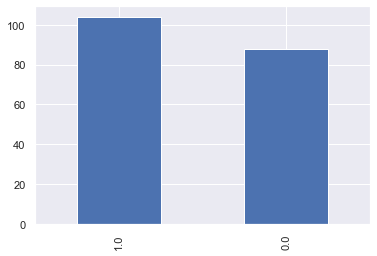

In [297]:
df['target_rise_fall'].value_counts().plot(kind='bar')

# Random Forest

In [715]:
df = GetCategoryDataset('all')
df = DefineHistoricalPrices(df)
df = DefineTarget(df)
df = ApplyScaler(df)
df = shuffle(df)

X = df.loc[:, df.columns != 'target_rise_fall']
Y = df.loc[:, df.columns == 'target_rise_fall']

clf = RandomForestClassifier(n_estimators=101, max_depth = 12)
scores = cross_val_score(clf, X, Y.values.ravel(), cv=LeaveOneOut())
print(scores.mean())
acc.append(scores.mean())


0.953125


RandomForestClassifier(n_estimators=101)   
GaussianNB()  
clf = svm.SVC(gamma='scale', probability=True)  
KNeighborsClassifier(n_neighbors=5)  
svm.LinearSVC(penalty='l1',loss='squared_hinge',dual=False, max_iter = 15000)

In [709]:
acc = []
for x in range(1,2):

    df = GetCategoryDataset('all')
    df = DefineHistoricalPrices(df)
    df = DefineTarget(df)
    df = ApplyScaler(df)
    df = shuffle(df)

    X = df.loc[:, df.columns != 'target_rise_fall']
    Y = df.loc[:, df.columns == 'target_rise_fall']

    clf = svm.LinearSVC(penalty='l1',loss='squared_hinge',dual=False, max_iter = 15000)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
    clf.fit(X_train, y_train.values.ravel())
    y_pred = clf.predict(X_test)
    print("---------------------Summary------------------")
    print(classification_report(y_test,y_pred))
    print("----------------Confusion_matrix--------------")
    print(confusion_matrix(y_test,y_pred))
    print("--------------------Accuracy------------------")
    print(accuracy_score(y_test, y_pred))
    acc.append(accuracy_score(y_test, y_pred))
    #feature_importances = pd.DataFrame(clf.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
    #feature_importances.head(20)

    df_cm = confusion_matrix(y_test,y_pred)
        #plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
    plt.title('Confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.show()

    #probabilities = clf.fit(X_train, y_train.values.ravel()).predict_proba(X_test)
    #print(roc_auc_score(y_test, probabilities[:, 1]))
    
print (np.array(acc).mean())

---------------------Summary------------------
              precision    recall  f1-score   support

         0.0       0.44      0.65      0.52        17
         1.0       0.74      0.55      0.63        31

    accuracy                           0.58        48
   macro avg       0.59      0.60      0.58        48
weighted avg       0.63      0.58      0.59        48

----------------Confusion_matrix--------------
[[11  6]
 [14 17]]
--------------------Accuracy------------------
0.5833333333333334


0.5833333333333334


# Error distribution

In [177]:
final = pd.DataFrame(columns=['tomorow_percentage_rise_fall', 'predict'])

for x in range(1,5):
    df = GetCategoryDataset('all')
    df = DefineHistoricalPrices(df)
    df = DefineTarget(df)
    df = ApplyScaler(df)
    df = shuffle(df)

    X = df.loc[:, df.columns != 'target_rise_fall']
    Y = df.loc[:, df.columns == 'target_rise_fall']

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=0)

    percentageArr = X_test[['tomorow_percentage_rise_fall']].copy()
    X_test = X_test.drop(['tomorow_percentage_rise_fall'], axis = 1)
    X_train = X_train.drop(['tomorow_percentage_rise_fall'], axis = 1)

    clf = RandomForestClassifier(n_estimators=101, max_depth =15)
    clf.fit(X_train, y_train.values.ravel())
    y_pred = clf.predict(X_test)

    percentageArr['predict'] = y_pred

    percentageArr['size'] = np.abs(percentageArr.tomorow_percentage_rise_fall) 
    #percentageArr['size'] = np.where(percentageArr['size']<0.1, 0.1, percentageArr['size'])
    percentageArr.tomorow_percentage_rise_fall = percentageArr.tomorow_percentage_rise_fall.round(4)

    frames = [final, percentageArr]
    final = pd.concat(frames)
final['predict'] = np.where(final.predict == 1, "Nárast", "Pokles")

C:\Users\kriza\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\kriza\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\kriza\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\kriz

In [178]:
plt.figure(figsize=(16, 8))

ax = sns.barplot(x="tomorow_percentage_rise_fall", y="size", hue="predict", data=final)
plt.xticks(rotation='85')
ax.set_title('Distribúcia chýb modelu Náhodný les', fontsize = 20)
ax.set_ylabel("veľkosť zmeny ceny", fontsize = 18) 
ax.set_xlabel("percentuálna zmena ceny", fontsize = 18)
plt.setp(ax.get_legend().get_texts(), fontsize='22')
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 5 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
        
plt.show()



# Početnosť kategórii


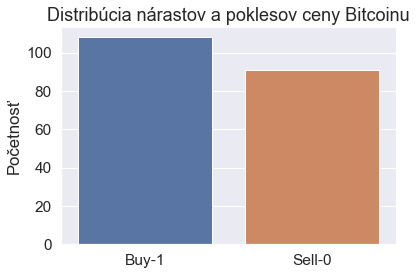

In [953]:
df = pd.read_csv("data_f.csv")
df['target'] = np.append(np.diff(df['close_price']), 0)
df['rise/fall'] = np.where(df['target']>=0, 'Buy-1', 'Sell-0')

ax = sns.countplot(df['rise/fall'])
ax.set_title('Distribúcia nárastov a poklesov ceny Bitcoinu', fontsize = 18)
ax.set_ylabel("Početnosť") 
ax.set_xlabel("") 
plt.show()

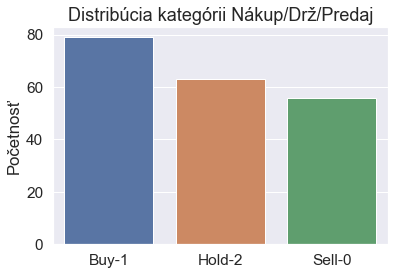

In [959]:
df = pd.read_csv("data_f.csv")
df['tomorow_percentage_rise_fall'] = df.close_price.pct_change()*100
df['tomorow_percentage_rise_fall'] = df['tomorow_percentage_rise_fall'].shift(-1)
df['rise/fall'] = df[['tomorow_percentage_rise_fall']].copy()
df['rise/fall'] = np.where(df['tomorow_percentage_rise_fall']>1.25, 'Buy-1', df['rise/fall'] )
df['rise/fall'] = np.where(df['tomorow_percentage_rise_fall']<-1.0, 'Sell-0', df['rise/fall'])
df['rise/fall'] = np.where(((df['tomorow_percentage_rise_fall']>=-1.00) & (df['tomorow_percentage_rise_fall']<=1.25)), 'Hold-2', df['rise/fall'])
df = df.dropna()

ax = sns.countplot(df['rise/fall'])
ax.set_title('Distribúcia kategórii Nákup/Drž/Predaj', fontsize = 18)
ax.set_ylabel("Početnosť") 
ax.set_xlabel("") 
plt.show()

RandomForestClassifier(n_estimators=101)   
GaussianNB()  
clf = svm.SVC(gamma='scale', probability=True)  
KNeighborsClassifier(n_neighbors=5)  
svm.LinearSVC(penalty='l1',loss='squared_hinge',dual=False, max_iter = 15000)  
btchistorical tweettrends news stockmarket cryptomarket all  

In [991]:
acc = []
for x in range(1,50):

    df = GetCategoryDataset('all')
    df = DefineHistoricalPrices(df)
    df = DefineThreeTarget(df)
    df = ApplyScaler(df)
    df = shuffle(df)

    X = df.loc[:, df.columns != 'target_rise_fall']
    Y = df.loc[:, df.columns == 'target_rise_fall']

    clf = svm.LinearSVC(penalty='l1',loss='squared_hinge',dual=False, max_iter = 15000)  
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
    clf.fit(X_train, y_train.values.ravel())
    y_pred = clf.predict(X_test)
    print("---------------------Summary------------------")
    print(classification_report(y_test,y_pred))
    print("----------------Confusion_matrix--------------")
    print(confusion_matrix(y_test,y_pred))
    print("--------------------Accuracy------------------")
    print(accuracy_score(y_test, y_pred))
    acc.append(accuracy_score(y_test, y_pred))
    #feature_importances = pd.DataFrame(clf.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
    #feature_importances.head(20)

    df_cm = confusion_matrix(y_test,y_pred)
        #plt.figure(figsize = (10,7))
    #sns.set(font_scale=1.4)#for label size
    #sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
    #plt.title('Confusion matrix')
    #plt.ylabel('True label')
    #plt.xlabel('Predicted label')

    #plt.show()

    #probabilities = clf.fit(X_train, y_train.values.ravel()).predict_proba(X_test)
    #print(roc_auc_score(y_test, probabilities[:, 1]))
    
print (np.array(acc).mean())

Buy73
Sell54
Hold65
---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.41      0.47      0.44        19
        Hold       0.39      0.50      0.44        14
        Sell       0.25      0.13      0.17        15

    accuracy                           0.38        48
   macro avg       0.35      0.37      0.35        48
weighted avg       0.35      0.38      0.36        48

----------------Confusion_matrix--------------
[[9 6 4]
 [5 7 2]
 [8 5 2]]
--------------------Accuracy------------------
0.375
Buy73
Sell54
Hold65
---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.59      0.57      0.58        23
        Hold       0.47      0.44      0.45        16
        Sell       0.09      0.11      0.10         9

    accuracy                           0.44        48
   macro avg       0.38      0.37      0.38        48
weighted avg       0.46      0.

C:\Users\kriza\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.44      0.47      0.46        17
        Hold       0.71      0.63      0.67        19
        Sell       0.31      0.33      0.32        12

    accuracy                           0.50        48
   macro avg       0.49      0.48      0.48        48
weighted avg       0.51      0.50      0.51        48

----------------Confusion_matrix--------------
[[ 8  3  6]
 [ 4 12  3]
 [ 6  2  4]]
--------------------Accuracy------------------
0.5
Buy73
Sell54
Hold65


C:\Users\kriza\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.32      0.62      0.42        13
        Hold       0.62      0.42      0.50        19
        Sell       0.20      0.12      0.15        16

    accuracy                           0.38        48
   macro avg       0.38      0.39      0.36        48
weighted avg       0.40      0.38      0.36        48

----------------Confusion_matrix--------------
[[ 8  1  4]
 [ 7  8  4]
 [10  4  2]]
--------------------Accuracy------------------
0.375
Buy73
Sell54
Hold65
---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.55      0.33      0.41        18
        Hold       0.52      0.70      0.60        20
        Sell       0.30      0.30      0.30        10

    accuracy                           0.48        48
   macro avg       0.45      0.44      0.44        48
weighted avg       0.48      0.48      0.4

C:\Users\kriza\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.35      0.54      0.42        13
        Hold       0.56      0.50      0.53        20
        Sell       0.10      0.07      0.08        15

    accuracy                           0.38        48
   macro avg       0.34      0.37      0.34        48
weighted avg       0.36      0.38      0.36        48

----------------Confusion_matrix--------------
[[ 7  3  3]
 [ 4 10  6]
 [ 9  5  1]]
--------------------Accuracy------------------
0.375
Buy73
Sell54
Hold65


C:\Users\kriza\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.50      0.61      0.55        18
        Hold       0.30      0.23      0.26        13
        Sell       0.38      0.35      0.36        17

    accuracy                           0.42        48
   macro avg       0.39      0.40      0.39        48
weighted avg       0.40      0.42      0.41        48

----------------Confusion_matrix--------------
[[11  5  2]
 [ 2  3  8]
 [ 9  2  6]]
--------------------Accuracy------------------
0.4166666666666667
Buy73
Sell54
Hold65


C:\Users\kriza\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.56      0.56      0.56        18
        Hold       0.53      0.53      0.53        15
        Sell       0.47      0.47      0.47        15

    accuracy                           0.52        48
   macro avg       0.52      0.52      0.52        48
weighted avg       0.52      0.52      0.52        48

----------------Confusion_matrix--------------
[[10  4  4]
 [ 3  8  4]
 [ 5  3  7]]
--------------------Accuracy------------------
0.5208333333333334
Buy73
Sell54
Hold65


C:\Users\kriza\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.61      0.70      0.65        20
        Hold       0.64      0.50      0.56        14
        Sell       0.36      0.36      0.36        14

    accuracy                           0.54        48
   macro avg       0.53      0.52      0.52        48
weighted avg       0.54      0.54      0.54        48

----------------Confusion_matrix--------------
[[14  1  5]
 [ 3  7  4]
 [ 6  3  5]]
--------------------Accuracy------------------
0.5416666666666666
Buy73
Sell54
Hold65
---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.41      0.37      0.39        19
        Hold       0.33      0.50      0.40        12
        Sell       0.38      0.29      0.33        17

    accuracy                           0.38        48
   macro avg       0.38      0.39      0.37        48
weighted avg       0.38      

C:\Users\kriza\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.30      0.35      0.32        17
        Hold       0.53      0.53      0.53        15
        Sell       0.23      0.19      0.21        16

    accuracy                           0.35        48
   macro avg       0.35      0.36      0.35        48
weighted avg       0.35      0.35      0.35        48

----------------Confusion_matrix--------------
[[6 2 9]
 [6 8 1]
 [8 5 3]]
--------------------Accuracy------------------
0.3541666666666667
Buy73
Sell54
Hold65
---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.29      0.19      0.23        21
        Hold       0.21      0.31      0.25        13
        Sell       0.13      0.14      0.14        14

    accuracy                           0.21        48
   macro avg       0.21      0.21      0.21        48
weighted avg       0.22      0.21     

C:\Users\kriza\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.60      0.71      0.65        17
        Hold       0.61      0.55      0.58        20
        Sell       0.60      0.55      0.57        11

    accuracy                           0.60        48
   macro avg       0.60      0.60      0.60        48
weighted avg       0.60      0.60      0.60        48

----------------Confusion_matrix--------------
[[12  4  1]
 [ 6 11  3]
 [ 2  3  6]]
--------------------Accuracy------------------
0.6041666666666666
Buy73
Sell54
Hold65
---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.41      0.41      0.41        17
        Hold       0.42      0.62      0.50        13
        Sell       0.50      0.33      0.40        18

    accuracy                           0.44        48
   macro avg       0.44      0.45      0.44        48
weighted avg       0.45      

C:\Users\kriza\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.25      0.28      0.26        18
        Hold       0.47      0.35      0.40        20
        Sell       0.31      0.40      0.35        10

    accuracy                           0.33        48
   macro avg       0.34      0.34      0.34        48
weighted avg       0.35      0.33      0.34        48

----------------Confusion_matrix--------------
[[ 5  7  6]
 [10  7  3]
 [ 5  1  4]]
--------------------Accuracy------------------
0.3333333333333333
Buy73
Sell54
Hold65
---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.35      0.50      0.41        14
        Hold       0.37      0.39      0.38        18
        Sell       0.56      0.31      0.40        16

    accuracy                           0.40        48
   macro avg       0.42      0.40      0.40        48
weighted avg       0.43      

C:\Users\kriza\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.39      0.39      0.39        18
        Hold       0.19      0.25      0.21        12
        Sell       0.29      0.22      0.25        18

    accuracy                           0.29        48
   macro avg       0.29      0.29      0.28        48
weighted avg       0.30      0.29      0.29        48

----------------Confusion_matrix--------------
[[7 5 6]
 [5 3 4]
 [6 8 4]]
--------------------Accuracy------------------
0.2916666666666667
Buy73
Sell54
Hold65


C:\Users\kriza\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.40      0.30      0.34        20
        Hold       0.50      0.53      0.51        17
        Sell       0.33      0.45      0.38        11

    accuracy                           0.42        48
   macro avg       0.41      0.43      0.41        48
weighted avg       0.42      0.42      0.41        48

----------------Confusion_matrix--------------
[[6 6 8]
 [6 9 2]
 [3 3 5]]
--------------------Accuracy------------------
0.4166666666666667
Buy73
Sell54
Hold65


C:\Users\kriza\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.60      0.48      0.53        25
        Hold       0.44      0.67      0.53        12
        Sell       0.20      0.18      0.19        11

    accuracy                           0.46        48
   macro avg       0.41      0.44      0.42        48
weighted avg       0.47      0.46      0.45        48

----------------Confusion_matrix--------------
[[12  6  7]
 [ 3  8  1]
 [ 5  4  2]]
--------------------Accuracy------------------
0.4583333333333333
Buy73
Sell54
Hold65
---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.59      0.45      0.51        22
        Hold       0.38      0.53      0.44        15
        Sell       0.50      0.45      0.48        11

    accuracy                           0.48        48
   macro avg       0.49      0.48      0.48        48
weighted avg       0.50      

C:\Users\kriza\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.57      0.59      0.58        22
        Hold       0.58      0.44      0.50        16
        Sell       0.31      0.40      0.35        10

    accuracy                           0.50        48
   macro avg       0.49      0.48      0.48        48
weighted avg       0.52      0.50      0.50        48

----------------Confusion_matrix--------------
[[13  3  6]
 [ 6  7  3]
 [ 4  2  4]]
--------------------Accuracy------------------
0.5
Buy73
Sell54
Hold65
---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.39      0.35      0.37        20
        Hold       0.57      0.53      0.55        15
        Sell       0.25      0.31      0.28        13

    accuracy                           0.40        48
   macro avg       0.40      0.40      0.40        48
weighted avg       0.41      0.40      0.40 

C:\Users\kriza\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.46      0.55      0.50        20
        Hold       0.55      0.32      0.40        19
        Sell       0.08      0.11      0.09         9

    accuracy                           0.38        48
   macro avg       0.36      0.33      0.33        48
weighted avg       0.42      0.38      0.38        48

----------------Confusion_matrix--------------
[[11  2  7]
 [ 8  6  5]
 [ 5  3  1]]
--------------------Accuracy------------------
0.375
Buy73
Sell54
Hold65
---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.36      0.53      0.43        15
        Hold       0.47      0.39      0.42        18
        Sell       0.45      0.33      0.38        15

    accuracy                           0.42        48
   macro avg       0.43      0.42      0.41        48
weighted avg       0.43      0.42      0.4

C:\Users\kriza\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.18      0.11      0.14        18
        Hold       0.50      0.47      0.48        17
        Sell       0.19      0.31      0.24        13

    accuracy                           0.29        48
   macro avg       0.29      0.30      0.29        48
weighted avg       0.30      0.29      0.29        48

----------------Confusion_matrix--------------
[[ 2  4 12]
 [ 4  8  5]
 [ 5  4  4]]
--------------------Accuracy------------------
0.2916666666666667
Buy73
Sell54
Hold65


C:\Users\kriza\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.44      0.50      0.47        16
        Hold       0.38      0.32      0.34        19
        Sell       0.43      0.46      0.44        13

    accuracy                           0.42        48
   macro avg       0.42      0.43      0.42        48
weighted avg       0.41      0.42      0.41        48

----------------Confusion_matrix--------------
[[8 5 3]
 [8 6 5]
 [2 5 6]]
--------------------Accuracy------------------
0.4166666666666667
Buy73
Sell54
Hold65
---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.50      0.20      0.29        20
        Hold       0.58      0.55      0.56        20
        Sell       0.29      0.75      0.41         8

    accuracy                           0.44        48
   macro avg       0.45      0.50      0.42        48
weighted avg       0.50      0.44     

C:\Users\kriza\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.57      0.38      0.46        21
        Hold       0.53      0.50      0.51        18
        Sell       0.24      0.44      0.31         9

    accuracy                           0.44        48
   macro avg       0.45      0.44      0.43        48
weighted avg       0.49      0.44      0.45        48

----------------Confusion_matrix--------------
[[8 5 8]
 [4 9 5]
 [2 3 4]]
--------------------Accuracy------------------
0.4375
Buy73
Sell54
Hold65
---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.33      0.20      0.25        20
        Hold       0.39      0.47      0.43        19
        Sell       0.00      0.00      0.00         9

    accuracy                           0.27        48
   macro avg       0.24      0.22      0.23        48
weighted avg       0.29      0.27      0.27       

C:\Users\kriza\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.43      0.60      0.50        15
        Hold       0.60      0.45      0.51        20
        Sell       0.42      0.38      0.40        13

    accuracy                           0.48        48
   macro avg       0.48      0.48      0.47        48
weighted avg       0.50      0.48      0.48        48

----------------Confusion_matrix--------------
[[9 3 3]
 [7 9 4]
 [5 3 5]]
--------------------Accuracy------------------
0.4791666666666667
Buy73
Sell54
Hold65
---------------------Summary------------------
              precision    recall  f1-score   support

         Buy       0.42      0.53      0.47        15
        Hold       0.53      0.50      0.51        18
        Sell       0.42      0.33      0.37        15

    accuracy                           0.46        48
   macro avg       0.46      0.46      0.45        48
weighted avg       0.46      0.46     

# Classification SECTION

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC  
 - SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto_deprecated’, coef0=0.0, shrinking=True, probability=False, tol=0.001,    cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)  
 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier  
 - RandomForestClassifier(n_estimators=’warn’, criterion=’gini’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None)
 
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB
 - GaussianNB(priors=None, var_smoothing=1e-09)
 
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier  
 - KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, metric=’minkowski’, metric_params=None, n_jobs=None, **kwargs)


# Random Forrest whole set - bad target

In [28]:
###CLASSIFICATION###DONT MOVE PrepareDataset()  TO SEPARATE BLOCK  - DF must be initialized every time

dff = PrepareDataset()
clf, X_train = Predict(dff,scaler = StandardScaler(), classifier = RandomForestClassifier(n_estimators=101), columns = GetColumnSet())
feature_importances = pd.DataFrame(clf.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(10)

Selected columns>> ALL


(199, 17)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       1.00      0.96      0.98        23
        True       0.96      1.00      0.98        25

    accuracy                           0.98        48
   macro avg       0.98      0.98      0.98        48
weighted avg       0.98      0.98      0.98        48

----------------Confusion_matrix--------------
[[22  1]
 [ 0 25]]
--------------------Accuracy------------------
0.9791666666666666


importance
d_market_cap            0.611635
d_market_volume         0.045181
total_trans_fees        0.044783
d_num_of_transaction    0.042496
output_volume           0.036956
miners_revenue          0.036905
num_of_transaction      0.035137
d_output_volume         0.033685
d_miners_revenue        0.032260
d_total_trans_fees      0.031949

# Random Forrest just base features

In [323]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK 
dff = PrepareDataset()
rf, X_train = Predict(dff, scaler = StandardScaler(), classifier = RandomForestClassifier(n_estimators=101, random_state=0), columns = GetColumnSet('basic'))
feature_importances = pd.DataFrame(rf.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(10)

Selected columns>> ['target_rise_fall', 'd_price_move', 'market_volume', 'market_cap', 'num_of_transaction', 'miners_revenue', 'total_trans_fees', 'output_volume']


(197, 19)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.62      0.67      0.64        24
        True       0.64      0.58      0.61        24

    accuracy                           0.62        48
   macro avg       0.63      0.62      0.62        48
weighted avg       0.63      0.62      0.62        48

----------------Confusion_matrix--------------
[[16  8]
 [10 14]]
--------------------Accuracy------------------
0.625


importance
num_of_transaction    0.167511
market_cap            0.149721
total_trans_fees      0.146771
market_volume         0.143108
output_volume         0.136499
miners_revenue        0.132607
d_price_move          0.123782

# Random Forrest just difference features

In [324]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK 
dff = PrepareDataset()
rf, X_train = Predict(dff, scaler = StandardScaler(), classifier = RandomForestClassifier(n_estimators=101, random_state=0), columns = GetColumnSet('difference'))
feature_importances = pd.DataFrame(rf.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(10)

Selected columns>> ['target_rise_fall', 'd_price_move', 'd_market_volume', 'd_market_cap', 'd_num_of_transaction', 'd_miners_revenue', 'd_total_trans_fees', 'd_output_volume']


(197, 19)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.57      0.33      0.42        24
        True       0.53      0.75      0.62        24

    accuracy                           0.54        48
   macro avg       0.55      0.54      0.52        48
weighted avg       0.55      0.54      0.52        48

----------------Confusion_matrix--------------
[[ 8 16]
 [ 6 18]]
--------------------Accuracy------------------
0.5416666666666666


importance
d_market_volume         0.182702
d_total_trans_fees      0.158025
d_market_cap            0.141337
d_miners_revenue        0.132036
d_output_volume         0.131903
d_num_of_transaction    0.128658
d_price_move            0.125338

# GaussianNB - whole dataset

In [325]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK 
dff = PrepareDataset()
clf, X_train = Predict(dff,scaler = MinMaxScaler(feature_range=(-1, 1), copy=True) , classifier = GaussianNB())

(197, 19)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.62      0.75      0.68        24
        True       0.68      0.54      0.60        24

    accuracy                           0.65        48
   macro avg       0.65      0.65      0.64        48
weighted avg       0.65      0.65      0.64        48

----------------Confusion_matrix--------------
[[18  6]
 [11 13]]
--------------------Accuracy------------------
0.6458333333333334


# GaussianNB - base features

In [326]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK 
dff = PrepareDataset()
clf, X_train = Predict(dff,scaler = MinMaxScaler(feature_range=(-1, 1), copy=True) , classifier = GaussianNB(), columns = GetColumnSet("basic"))

Selected columns>> ['target_rise_fall', 'd_price_move', 'market_volume', 'market_cap', 'num_of_transaction', 'miners_revenue', 'total_trans_fees', 'output_volume']


(197, 19)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.69      0.46      0.55        24
        True       0.59      0.79      0.68        24

    accuracy                           0.62        48
   macro avg       0.64      0.62      0.61        48
weighted avg       0.64      0.62      0.61        48

----------------Confusion_matrix--------------
[[11 13]
 [ 5 19]]
--------------------Accuracy------------------
0.625


# GaussianNB - difference features

In [327]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK 
dff = PrepareDataset()
clf, X_train = Predict(dff,scaler = MinMaxScaler(feature_range=(-1, 1), copy=True) , classifier = GaussianNB(), columns = GetColumnSet("difference"))

Selected columns>> ['target_rise_fall', 'd_price_move', 'd_market_volume', 'd_market_cap', 'd_num_of_transaction', 'd_miners_revenue', 'd_total_trans_fees', 'd_output_volume']


(197, 19)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.53      0.33      0.41        24
        True       0.52      0.71      0.60        24

    accuracy                           0.52        48
   macro avg       0.52      0.52      0.50        48
weighted avg       0.52      0.52      0.50        48

----------------Confusion_matrix--------------
[[ 8 16]
 [ 7 17]]
--------------------Accuracy------------------
0.5208333333333334


# SVM - whole dataset

In [328]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK 
dff = PrepareDataset()
clf, X_train = Predict(dff,scaler = MinMaxScaler(feature_range=(-1, 1), copy=True), classifier = svm.SVC(gamma='scale'), columns = GetColumnSet())

Selected columns>> ALL


(197, 19)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.70      0.58      0.64        24
        True       0.64      0.75      0.69        24

    accuracy                           0.67        48
   macro avg       0.67      0.67      0.66        48
weighted avg       0.67      0.67      0.66        48

----------------Confusion_matrix--------------
[[14 10]
 [ 6 18]]
--------------------Accuracy------------------
0.6666666666666666


# SVM - base features

In [329]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK 
dff = PrepareDataset()
clf, X_train = Predict(dff,scaler = MinMaxScaler(feature_range=(-1, 1), copy=True), classifier = svm.SVC(gamma='scale'), columns = GetColumnSet("basic"))

Selected columns>> ['target_rise_fall', 'd_price_move', 'market_volume', 'market_cap', 'num_of_transaction', 'miners_revenue', 'total_trans_fees', 'output_volume']


(197, 19)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.75      0.50      0.60        24
        True       0.62      0.83      0.71        24

    accuracy                           0.67        48
   macro avg       0.69      0.67      0.66        48
weighted avg       0.69      0.67      0.66        48

----------------Confusion_matrix--------------
[[12 12]
 [ 4 20]]
--------------------Accuracy------------------
0.6666666666666666


# SVM - difference features

In [330]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK 
dff = PrepareDataset()
clf, X_train = Predict(dff,scaler = MinMaxScaler(feature_range=(-1, 1), copy=True), classifier = svm.SVC(gamma='scale'), columns = GetColumnSet("difference"))

Selected columns>> ['target_rise_fall', 'd_price_move', 'd_market_volume', 'd_market_cap', 'd_num_of_transaction', 'd_miners_revenue', 'd_total_trans_fees', 'd_output_volume']


(197, 19)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.33      0.12      0.18        24
        True       0.46      0.75      0.57        24

    accuracy                           0.44        48
   macro avg       0.40      0.44      0.38        48
weighted avg       0.40      0.44      0.38        48

----------------Confusion_matrix--------------
[[ 3 21]
 [ 6 18]]
--------------------Accuracy------------------
0.4375



# KNeighborsClassifier - whole dataset

In [331]:
dff = PrepareDataset()
clf, X_train = Predict(dff,scaler = MinMaxScaler(feature_range=(-1, 1), copy=True) , classifier = KNeighborsClassifier(n_neighbors=5), columns = GetColumnSet())

Selected columns>> ALL


(197, 19)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.72      0.54      0.62        24
        True       0.63      0.79      0.70        24

    accuracy                           0.67        48
   macro avg       0.68      0.67      0.66        48
weighted avg       0.68      0.67      0.66        48

----------------Confusion_matrix--------------
[[13 11]
 [ 5 19]]
--------------------Accuracy------------------
0.6666666666666666


# KNeighborsClassifier - base data

In [332]:
dff = PrepareDataset()
clf, X_train = Predict(dff,scaler = MinMaxScaler(feature_range=(-1, 1), copy=True) , classifier = KNeighborsClassifier(n_neighbors=5), columns = GetColumnSet("basic"))

Selected columns>> ['target_rise_fall', 'd_price_move', 'market_volume', 'market_cap', 'num_of_transaction', 'miners_revenue', 'total_trans_fees', 'output_volume']


(197, 19)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.64      0.67      0.65        24
        True       0.65      0.62      0.64        24

    accuracy                           0.65        48
   macro avg       0.65      0.65      0.65        48
weighted avg       0.65      0.65      0.65        48

----------------Confusion_matrix--------------
[[16  8]
 [ 9 15]]
--------------------Accuracy------------------
0.6458333333333334


# KNeighborsClassifier - difference data

In [333]:
dff = PrepareDataset()
clf, X_train = Predict(dff,scaler = MinMaxScaler(feature_range=(-1, 1), copy=True) , classifier = KNeighborsClassifier(n_neighbors=5), columns = GetColumnSet("difference"))

Selected columns>> ['target_rise_fall', 'd_price_move', 'd_market_volume', 'd_market_cap', 'd_num_of_transaction', 'd_miners_revenue', 'd_total_trans_fees', 'd_output_volume']


(197, 19)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.53      0.38      0.44        24
        True       0.52      0.67      0.58        24

    accuracy                           0.52        48
   macro avg       0.52      0.52      0.51        48
weighted avg       0.52      0.52      0.51        48

----------------Confusion_matrix--------------
[[ 9 15]
 [ 8 16]]
--------------------Accuracy------------------
0.5208333333333334
